In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import math
import json
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import missingno as msnco

%matplotlib inline
# Any results you write to the current directory are saved as output.
import random
import os

from autogluon.tabular import TabularDataset, TabularPredictor
import autogluon.core as ag

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0" 

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(69) 

pd.set_option('mode.chained_assignment',  None)

In [ ]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [ ]:
s = train_df[train_df['Estimated_Departure_Time'].isna() & ~train_df['Estimated_Arrival_Time'].isna()]
t = train_df[~train_df['Estimated_Departure_Time'].isna() & train_df['Estimated_Arrival_Time'].isna()]
test_s = test_df[test_df['Estimated_Departure_Time'].isna() & ~test_df['Estimated_Arrival_Time'].isna()]
test_t = test_df[~test_df['Estimated_Departure_Time'].isna() & test_df['Estimated_Arrival_Time'].isna()]

In [ ]:
test_df[test_df['Estimated_Departure_Time'].isna() & test_df['Estimated_Arrival_Time'].isna()].isna().sum()

ID                              0
Month                           0
Day_of_Month                    0
Estimated_Departure_Time    11928
Estimated_Arrival_Time      11928
Cancelled                       0
Diverted                        0
Origin_Airport                  0
Origin_Airport_ID               0
Origin_State                 1239
Destination_Airport             0
Destination_Airport_ID          0
Destination_State            1209
Distance                        0
Airline                      1286
Carrier_Code(IATA)           1331
Carrier_ID(DOT)              1308
Tail_Number                     0
dtype: int64

In [ ]:
mean_time = 232
train_df['Estimated_Departure_Time'][train_df['Estimated_Departure_Time'].isna() & ~train_df['Estimated_Arrival_Time'].isna()] = s['Estimated_Arrival_Time'] - mean_time
train_df['Estimated_Arrival_Time'][~train_df['Estimated_Departure_Time'].isna() & train_df['Estimated_Arrival_Time'].isna()] = t['Estimated_Departure_Time'] + mean_time

In [ ]:
test_df['Estimated_Departure_Time'][test_df['Estimated_Departure_Time'].isna() & ~test_df['Estimated_Arrival_Time'].isna()] = test_s['Estimated_Arrival_Time'] - mean_time
test_df['Estimated_Arrival_Time'][~test_df['Estimated_Departure_Time'].isna() & test_df['Estimated_Arrival_Time'].isna()] = test_t['Estimated_Departure_Time'] + mean_time

In [ ]:
train_df.drop(['Cancelled', 'Diverted','Origin_State','Origin_Airport_ID','Destination_Airport_ID','Destination_State','Carrier_Code(IATA)'], axis=1, inplace=True)
test_df.drop(['Cancelled', 'Diverted','Origin_State','Origin_Airport_ID','Destination_Airport_ID','Destination_State','Carrier_Code(IATA)'], axis=1, inplace=True)

In [ ]:
train_df['Estimated_Departure_Time'] = train_df['Estimated_Departure_Time'].apply(lambda x: x+2359 if x<0 else x)
train_df['Estimated_Arrival_Time'] = train_df['Estimated_Arrival_Time'].apply(lambda x: x-2400 if x>2400 else x)
test_df['Estimated_Departure_Time'] = test_df['Estimated_Departure_Time'].apply(lambda x: x+2359 if x<0 else x)
test_df['Estimated_Arrival_Time'] = test_df['Estimated_Arrival_Time'].apply(lambda x: x-2400 if x>2400 else x)

In [ ]:
train_df_drop = train_df.dropna().copy()

In [ ]:
airline_values = train_df_drop.Airline.unique()
airline_keys = train_df_drop['Carrier_ID(DOT)'].unique()
airline_dict = dict(zip(airline_keys, airline_values))

In [ ]:
s = train_df[train_df['Airline'].isna() & ~train_df['Carrier_ID(DOT)'].isna()]
t = train_df[train_df['Carrier_ID(DOT)'].isna() & ~train_df['Airline'].isna()]
test_s = test_df[test_df['Airline'].isna() & ~test_df['Carrier_ID(DOT)'].isna()]


In [ ]:
train_df['Airline'][train_df['Airline'].isna() & ~train_df['Carrier_ID(DOT)'].isna()] = s['Carrier_ID(DOT)'].map(airline_dict)
test_df['Airline'][test_df['Airline'].isna() & ~test_df['Carrier_ID(DOT)'].isna()] = test_s['Carrier_ID(DOT)'].map(airline_dict)

#train_df['Carrier_ID(DOT)'][train_df['Carrier_ID(DOT)'].isna() & ~train_df['Airline'].isna()] = t['Airline']

In [ ]:
train_df_drop.drop(['Carrier_ID(DOT)', 'Tail_Number'], axis=1, inplace=True)

In [ ]:
test_df.drop(['Carrier_ID(DOT)', 'Tail_Number'], axis=1, inplace=True)

In [ ]:
test_df.isna().sum()

ID                              0
Month                           0
Day_of_Month                    0
Estimated_Departure_Time    11928
Estimated_Arrival_Time      11928
Origin_Airport                  0
Destination_Airport             0
Distance                        0
Airline                     11543
dtype: int64

In [ ]:
map_dic = {'Not_Delayed' : 0, 'Delayed' : 1}
train_df_drop['Delay'] = train_df_drop['Delay'].map(map_dic)

In [ ]:
# #0-2400 0부터 24로 시간순서대로 indexing
# def arr_time(x):
#     a= [i for i in range(600,2401,100)]
#     a[-1] = 2401
#     if x < a[0]:
#         return str((a[0] - 100)//100)
#     for i in range(len(a)-1):
#         if x >= a[i] and x < a[i+1]:
#             return str(a[i]//100)

In [ ]:
# train_df['Estimated_Departure_Time'] = train_df['Estimated_Departure_Time'].astype('int')
# train_df['Departure_Block'] = train_df['Estimated_Departure_Time'].apply(lambda x: arr_time(x))

In [ ]:
train_df_drop['Year'] = train_df_drop['Month']*100+ train_df_drop['Day_of_Month']
test_df['Year'] = test_df['Month']*100 + test_df['Day_of_Month']

In [ ]:
final_df = train_df_drop[['Year', 'Estimated_Departure_Time', 'Estimated_Arrival_Time','Origin_Airport','Destination_Airport','Distance','Airline','Delay' ]].reset_index(drop=True)
test_final_df = test_df[['Year', 'Estimated_Departure_Time', 'Estimated_Arrival_Time','Origin_Airport','Destination_Airport','Distance','Airline']].reset_index(drop=True)

In [ ]:
test_df.isna().sum()

ID                              0
Month                           0
Day_of_Month                    0
Estimated_Departure_Time    11928
Estimated_Arrival_Time      11928
Origin_Airport                  0
Destination_Airport             0
Distance                        0
Airline                     11543
Year                            0
dtype: int64

In [ ]:
label = 'Delay'
eval_metric = 'f1_macro'
time_limit = 3600*3

In [ ]:
predictor = TabularPredictor(
    label=label, problem_type='binary', eval_metric=eval_metric
).fit(final_df, 
      presets='best_quality',
      num_stack_levels=3,
      #excluded_model_types = excluded_model_types,
      time_limit=time_limit, num_gpus=1)

No path specified. Models will be saved in: "AutogluonModels/ag-20230410_034007/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=3, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 10800s
AutoGluon will save models to "AutogluonModels/ag-20230410_034007/"
AutoGluon Version:  0.7.0
Python Version:     3.8.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #154-Ubuntu SMP Thu Jan 5 17:03:22 UTC 2023
Train Data Rows:    200288
Train Data Columns: 7
Label Column: Delay
Preprocessing data ...
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    517143.66 MB
	Train Data (Original)  Memory Usage: 45.87 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the 

Fitting model: NeuralNetTorch_BAG_L2 ... Training model for up to 3146.58s of the 7847.39s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	0.5518	 = Validation score   (f1_macro)
	1796.71s	 = Training   runtime
	0.7s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 1348.07s of the 6048.89s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy
	0.4516	 = Validation score   (f1_macro)
	1.47s	 = Training   runtime
	0.05s	 = Validation runtime
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L3 ... Training model for up to 375.9s of the 6045.5s of remaining time.
	0.5518	 = Validation score   (f1_macro)
	69.25s	 = Training   runtime
	0.27s	 = Validation runtime
Fitting 11 L3 models ...
Fitting model: LightGBMXT_BAG_L3 ... Training model for up to 3982.98s of the 5975.96s of remaining time.
	Fitting 8 child models (S1F1 -

In [ ]:
predictor = TabularPredictor.load("./ag-20230409_030825/")

In [ ]:
ls

ag-20230406_114240/  ag-20230409_030825/
ag-20230407_020252/  ag-20230409_051753/


In [ ]:
predictor.leaderboard(final_df, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,KNeighborsDist_BAG_L1,1.000000,0.496278,0.356335,0.382979,0.157069,0.356335,0.382979,0.157069,1,True,2
1,RandomForestGini_BAG_L1,0.823690,0.468694,0.610021,5.542155,3.026951,0.610021,5.542155,3.026951,1,True,5
2,RandomForestEntr_BAG_L1,0.815691,0.465425,0.633449,5.859902,3.533241,0.633449,5.859902,3.533241,1,True,6
3,NeuralNetTorch_BAG_L3,0.618849,0.525545,53.405682,50.072976,5985.111761,5.339469,0.735497,1265.086686,3,True,36
4,WeightedEnsemble_L4,0.618849,0.525545,53.407449,50.339400,6053.291268,0.001767,0.266425,68.179507,4,True,38
5,NeuralNetFastAI_BAG_L3,0.605529,0.517746,62.138964,51.108477,5147.775443,14.072751,1.770998,427.750367,3,True,34
6,NeuralNetTorch_BAG_L4,0.603781,0.527235,79.358934,75.640275,8124.119720,5.543111,0.736567,1635.486130,4,True,48
7,WeightedEnsemble_L5,0.603781,0.527235,79.360802,75.907399,8192.561597,0.001868,0.267124,68.441877,5,True,50
8,NeuralNetTorch_BAG_L1,0.598900,0.524035,2.783823,0.378163,1755.832071,2.783823,0.378163,1755.832071,1,True,12
9,WeightedEnsemble_L2,0.598900,0.524035,2.785474,0.645372,1836.717170,0.001651,0.267209,80.885099,2,True,14


In [ ]:
predictor.feature_importance(final_df)

Computing feature importance via permutation shuffling for 8 features using 5000 rows with 5 shuffle sets...
	221.19s	= Expected runtime (44.24s per shuffle set)
	54.43s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
Year,0.028763,0.005593,0.000163,5,0.040279,0.017247
Estimated_Departure_Time,0.021519,0.006612,0.000947,5,0.035132,0.007905
Estimated_Arrival_Time,0.017032,0.007372,0.003334,5,0.032211,0.001854
Origin_Airport,0.010644,0.008676,0.025863,5,0.028507,-0.007219
Airline,0.010583,0.006230,0.009564,5,0.023411,-0.002244
Destination_Airport,0.001569,0.005741,0.287038,5,0.013389,-0.010251
Distance,0.001559,0.007822,0.339427,5,0.017665,-0.014547
index,0.000242,0.007161,0.471733,5,0.014985,-0.014502


In [ ]:
test_data = TabularDataset(test_final_df)

y_pred = predictor.predict_proba(test_data)
y_pred.head()

,0,1
0,0.904940,0.095060
1,0.689831,0.310169
2,0.597543,0.402457
3,0.620793,0.379207
4,0.782252,0.217748


In [ ]:
sub_csv = pd.read_csv('./sample_submission.csv')

In [ ]:
sub_csv['Not_Delayed'] = y_pred[0]
sub_csv['Delayed'] = y_pred[1]

In [ ]:
sub_csv

,ID,Not_Delayed,Delayed
0,TEST_000000,0.904940,0.095060
1,TEST_000001,0.689831,0.310169
2,TEST_000002,0.597543,0.402457
3,TEST_000003,0.620793,0.379207
4,TEST_000004,0.782252,0.217748
...,...,...,...
999995,TEST_999995,0.704050,0.295950
999996,TEST_999996,0.901988,0.098012
999997,TEST_999997,0.388869,0.611131
999998,TEST_999998,0.660834,0.339166


In [ ]:
sub_csv.to_csv('baseline_submission.csv', index=False)

<Axes: >

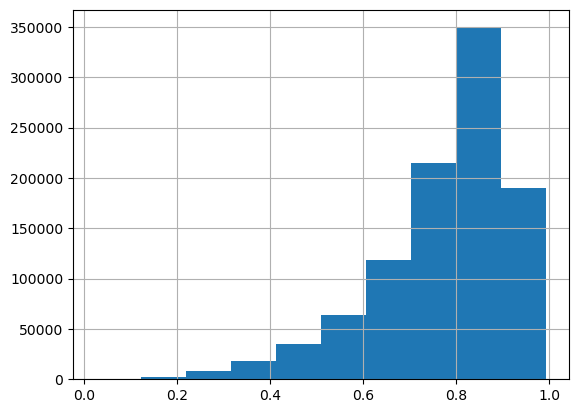

In [ ]:
sub_csv['Not_Delayed'].hist(bins=10)

In [ ]:
sub_csv['Not_Delayed'] = sub_csv[]